# Generating the Trophic State and Turbidity Timeseries for a Waterbody for SDG 6.6.1 reporting

## Background

The SDG indicator 6.6.1 measures the change in the extent of water-related ecosystems over time. 
This change can be measured using one or more of the following physical parameters: spatial area, quantity or volume of water and water quality 
[(UNEP, 2023)](https://grasdatastorage.blob.core.windows.net/sdg661/SDG%20indicator%20661%20methodology_English_update.pdf). 
The SDG Indicator 6.6.1 default methodology (i.e. the currently documented method that can be used globally) uses the Copernicus Global Land Service (CGLS) 300m resolution  [2002-2012](https://doi.org/10.2909/b93df0ed-c128-4984-ab1d-6f8f49b7ee680), [2016-2024](https://doi.org/10.2909/b8e48c8d-f44e-40eb-9583-4a3254c2bbb3)  and [2024-present](https://doi.org/10.2909/801137b8-9575-43ef-a073-140b663cc61c) Lake Water Quality products, to measure water quality for **4,200** lakes globally. 
This data includes two lake water parameters, an estimate of Trophic State Index (TSI) and Turbidity (TUR) which may be used to infer a particular state, or quality, of a freshwater body.
Trophic State Index refers to the degree at which organic matter accumulates in the waterbody and is most commonly used in relation to monitoring of
eutrophication.
Turbidity is a key indicator of water clarity, quantifying the haziness of water and acting as an indicator of underwater light availability. 
Trophic State Index is derived from phytoplankton biomass by proxy of chlorophyll-a and Turbidity is derived from suspended solids concentration estimates. 

To calculate the Turbidity and Trophic State Index statistics, a baseline reference period has been produced comprising monthly averages across the 5 years of observations for the period 2006 - 2010. 
From these five years of data, 12 monthly averages (one for each month of the year) for both trophic state and turbidity, were derived.

A further set of observations are then used to calculate change against the baseline data comprising monthly data from the target years 2017 - 2021.
The monthly averages for these five years have been derived. 

The deviation from the corresponding monthly multiannual baseline is computed using the following equation:
$$
\frac{\text{Month}_\text{average} - \text{Month}_\text{baseline}}{\text{Month}_\text{baseline}} \times 100 
$$

For each month, the total number of pixels with valid observations in a lake is counted and the relative share of pixels falling within the following deviation ranges: < 25 per cent (low), 25–50 per cent (medium), 50–100 per cent (high), > 100 per cent (extreme) is calculated.

A corresponding annual deviation synthesis is also produced and for each target year the number of “affected” lakes relative to the total number of lakes within a country is computed and reported. The two statistics reported at national scale for the sub-indicator 1.4 water quality of lakes (turbidity and trophic state) are:
- EN_LKW_QLTRB - Lake water quality turbidity (%)
- EN_LKW_QLTRST - Lake water quality trophic state (%) 

An affected lake is defined as a lake where the following conditions apply: the sum of the number of pixels in the high and extreme categories is greater than the sum of pixels in the low and medium categories i.e. (high+extreme) > (low+medium).

## Description

This notebook demonstrates how to derive the monthly and yearly Trophic State and Turbidity timeseries for a waterbody from the Copernicus Global Land Service – Lake Water Quality 300m global 10-daily products, for **311** lakes in Africa. 

This notebook can be run for a number of lakes in a country to get the final "affected" classification for the lakes and then aggregated for national level SDG 6.6.1 reporting.

___

## Getting Started

### Load required libraries

Load the python packages required for the analysis.

In [1]:
import calendar
from datetime import datetime

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import shapely.wkt
import xarray as xr
from datacube import Datacube
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.waterbodies import get_waterbodies
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry
from odc.geo.xr import assign_crs, rasterize
from shapely.geometry import box

### Connect to datacube

Connect to the datacube and specify a name for the session. 
The session name does not have an effect on the analysis but is helpful when tracking down issues with database queries.

The resulting `dc` object is what we use to access all the data contained within the Digital Earth Africa datacube.

In [2]:
dc = Datacube(app="WaterQuality")

### Create local dask cluster

Set up a dask client using the `create_local_dask_cluster` function.
A print out should appear, displaying information about the **Client** and the **Cluster**.
For now, we're most interested in the hyperlink after the Dashboard.
Use the hyperlink after the **Dashboard:** heading, which should look something like `/user/<email>/proxy/8787/status`, where `<email>` is your email for the DE Africa Sandbox.
This link provides a way for you to view how any computations you run are progressing. 

In [3]:
# Connect to local dask cluster
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/8787/status,
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39655,Workers: 1
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:38907,Total threads: 4
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/39887/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:37813,


### Define the area of interest

Import a GeoJSON `.geojson` or ESriShapefile  `.shp` containing the bounding box geometry that delineates the waterbody of interest.

In [4]:
# Load the waterbody bounding box as a GeoDataFrame.
waterbody_bbox = gpd.read_file("lakemweru.geojson").to_crs("EPSG:4326")
waterbody_bbox

,geometry
0,"POLYGON ((29.16771 -8.41049, 28.31571 -8.41049..."


Convert the loaded area of interest `shapely.Geometry` to a `odc.geo.geom.Geometry` object to be used when loading data from the datacube.

In [5]:
# Convert the geometry to and odc.geo.geom.Geometry 
bbox_geom = Geometry(geom=waterbody_bbox.iloc[0].geometry, crs=waterbody_bbox.crs)

View the geometry on an interactive `folium` leaflet map.

In [6]:
bbox_geom.explore(zoom_start=7)

## Get monthly averages for the baseline reference period

### Load water quality data for the baseline period

The first step in getting the 12 monthly averages for the baseline reference period for both trophic state and turbidy is to load the Trophic State and Turbidity data available for the waterbody area and the baseline period time range. 

The cell below lists all the Lake Water Quality products that are currently available in the Digital Earth Africa datacube.

In [7]:
# Get all the products avialable in the datacube as DataFrame
products_df = dc.list_products()
# Filter the DataFrame by name to list only the Lake Water Quality products. 
products_df = products_df.loc[products_df["name"].str.contains("cgls_lwq")]
products_df

,name,description,license,default_crs,default_resolution
name,,,,,
cgls_lwq100_2019_2024,cgls_lwq100_2019_2024,Copernicus Global Land Service – Lake Water Qu...,None,EPSG:4326,"(-0.000898, 0.000898)"
cgls_lwq100_2024_nrt,cgls_lwq100_2024_nrt,Copernicus Global Land Service – Lake Water Qu...,None,EPSG:4326,"(-0.000898, 0.000898)"
cgls_lwq300_2002_2012,cgls_lwq300_2002_2012,Copernicus Global Land Service – Lake Water Qu...,None,EPSG:4326,"(-0.0022, 0.0022)"
cgls_lwq300_2016_2024,cgls_lwq300_2016_2024,Copernicus Global Land Service – Lake Water Qu...,None,EPSG:4326,"(-0.0022, 0.0022)"
cgls_lwq300_2024_nrt,cgls_lwq300_2024_nrt,Copernicus Global Land Service – Lake Water Qu...,None,EPSG:4326,"(-0.0022, 0.0022)"


> The SDG Indicator 6.6.1 methodology uses the Copernicus Land Monitoring Service 300m resolution products, hence this notebook will use the products: `cgls_lwq300_2002_2012`, `cgls_lwq300_2016_2024` and `cgls_lwq100_2024_nrt`.

Each product in the datacube is associated with a range of available measurements. 
Measurements can be individual satellite bands or statistical product summaries. 

The cell below lists all the measurements associated with a Lake Water Quality product and includes a range of technical information about each measurement such as any aliases which can be used to load the data, the data type or dtype, any flags_definition that are associated with the measurement (this information is used for tasks like cloud masking), and the measurement's nodata value.

Run the following cell to explore all the available measurements associated with the Lake Water Quality product `cgls_lwq300_2002_2012`.

In [8]:
product = "cgls_lwq300_2002_2012"

measurements_df = dc.list_measurements()
measurements_df.loc[product]

,name,dtype,units,nodata,aliases,flags_definition,add_offset,scale_factor
measurement,,,,,,,,
first_obs,first_obs,float32,1,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN
last_obs,last_obs,float32,1,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN
n_obs_quality_risk_sum,n_obs_quality_risk_sum,float32,1,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN
num_obs,num_obs,int32,1,0,NaN,NaN,NaN,NaN
stats_valid_obs_tsi_sum,stats_valid_obs_tsi_sum,float32,1,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN
stats_valid_obs_turbidity_sum,stats_valid_obs_turbidity_sum,float32,1,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN
trophic_state_index,trophic_state_index,float32,1,9969210000000000000000000000000000000,[TSI],NaN,NaN,NaN
turbidity_mean,turbidity_mean,float32,NTU,9969210000000000000000000000000000000,[turbidity],NaN,NaN,NaN
turbidity_sigma,turbidity_sigma,float32,NTU,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN


The baseline reference period is 2006 - 2012. The product `cgls_lwq300_2002_2012` has data available for the African continent for this time range.
You can visit the  [Metadata Explorer](https://explorer.digitalearth.africa/products) page for this product to view its data availability [https://explorer.digitalearth.africa/products/cgls_lwq300_2002_2012](https://explorer.digitalearth.africa/products/cgls_lwq300_2002_2012).

Load the Trophic State Index (`TSI`) and Turbidity (`turbidity`) measurements for the  `cgls_lwq300_2002_2012` product for the baseline period and waterbody area. 

> Visit the notebook [Loading data from Digital Earth Africa](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/main/Beginners_guide/03_Loading_data.ipynb) for more information on how to load data from the Digital Earth Africa datacube

In [9]:
# Load trophic state and turbidity data for the baseline period
baseline_ds = dc.load(product=["cgls_lwq300_2002_2012"],
                      measurements=["TSI", "turbidity"],
                      geopolygon=bbox_geom,
                      output_crs="EPSG:6933",
                      resolution=(-300,300),
                      time=("2006", "2010"))
baseline_ds

<xarray.Dataset> Size: 194MB
Dimensions:      (time: 180, y: 489, x: 275)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2006-01-05T23:59:59.500000 ... 201...
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
Data variables:
    TSI          (time, y, x) float32 97MB 9.969e+36 9.969e+36 ... 9.969e+36
    turbidity    (time, y, x) float32 97MB 9.969e+36 9.969e+36 ... 9.969e+36
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

The variable `baseline_ds` has returned an `xarray.Dataset` containing all data that matched the spatial (`x` and `y` dimensions) and temporal (`time` dimension) query parameters inputted into `dc.load`. 
The Trophic State Index data is contained  in the `TSI` data variable of the `xarray.Dataset` and the Turbidity data is contained in the `turbidity` data variable. 

Mask the no data value in the Trophic State Index (`TSI`) and Turbidity (`turbidity`) data variables. 
This will limit the analysis to valid pixels where there is data. 
The no data value for each measurement is provided in the attributes of each data variable.

In [10]:
# View the attributes for the TSI data variable
var = "TSI"
baseline_ds[var].attrs

{'units': '1',
 'nodata': 9969210000000000000000000000000000000,
 'crs': 'EPSG:6933',
 'grid_mapping': 'spatial_ref'}

In [11]:
# Mask no data in the trophic_state_index and turbidity bands
var = "TSI"
baseline_ds[var] = baseline_ds[var].where(baseline_ds[var]!=float(baseline_ds[var].nodata))

var = "turbidity"
baseline_ds[var] = baseline_ds[var].where(baseline_ds[var]!=float(baseline_ds[var].nodata))

baseline_ds

<xarray.Dataset> Size: 194MB
Dimensions:      (time: 180, y: 489, x: 275)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2006-01-05T23:59:59.500000 ... 201...
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
Data variables:
    TSI          (time, y, x) float32 97MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 97MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

To verify that the no data values have been masked, print the maximum value of each data variable.

In [12]:
print(baseline_ds.max())

<xarray.Dataset> Size: 20B
Dimensions:      ()
Coordinates:
    spatial_ref  int32 4B 6933
Data variables:
    TSI          float64 8B 100.0
    turbidity    float64 8B 433.2


The maximum values for the TSI and turbidity data variables are reasonable, which shows that the no data values have been masked appropriately.

### Resample the baseline decadal timeseries

All the CGLS Lake Water Quality products are decadal products i.e. their temporal resolution is 10 days.
To produce the required 12 monthly averages for the baseline period you need to downsample the loaded data to a temporal resolution of 1 month. 

In [13]:
# Resample the baseline period data to a monthly timeseries
baseline_monthly_timeseries = baseline_ds.resample(time="1ME").mean()
baseline_monthly_timeseries

<xarray.Dataset> Size: 65MB
Dimensions:      (time: 60, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2006-01-31 2006-02-28 ... 2010-12-31
Data variables:
    TSI          (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

Plot the data for a single month from our downsampled Trophic State Index and turbidity data.

> [Xarray](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/main/Beginners_guide/07_Intro_to_xarray.ipynb) uses zero-based indexing for [positional indexing](https://docs.xarray.dev/en/stable/user-guide/indexing.html#indexing-and-selecting-data), similar to [NumPy](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/main/Beginners_guide/06_Intro_to_numpy.ipynb). This means that the first element in a dimension is accessed using index 0.

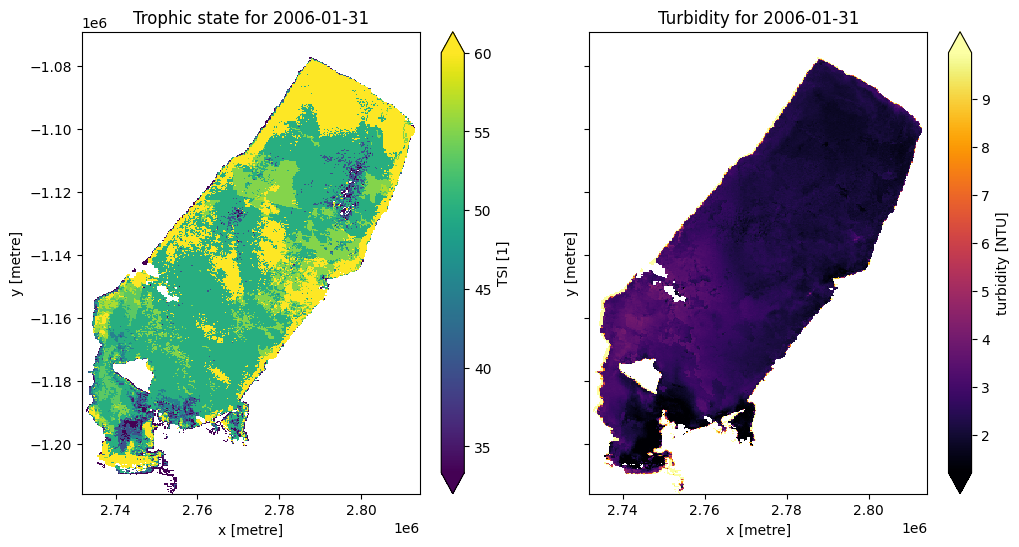

In [14]:
# Select the first month from the xarray.Dataset
to_plot = baseline_monthly_timeseries.isel(time=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)
to_plot["TSI"].plot(ax=ax[0], cmap="viridis", robust=True)
ax[0].set_title(f"Trophic state for {to_plot.time.values.astype('datetime64[D]')}")

to_plot["turbidity"].plot(ax=ax[1], cmap="inferno", robust=True)
ax[1].set_title(f"Turbidity for {to_plot.time.values.astype('datetime64[D]')}")
plt.show();

### Get monthly averages

From the five year monthly timeseries of observations, derive the 12 monthly averages (one for each month of the year) for both trophic state and turbidity.

In [15]:
# Get the long term mean for each month
baseline_monthly_long_term_mean = baseline_monthly_timeseries.groupby("time.month").mean()
baseline_monthly_long_term_mean

<xarray.Dataset> Size: 13MB
Dimensions:      (month: 12, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    TSI          (month, y, x) float32 6MB nan nan nan nan ... nan nan nan nan
    turbidity    (month, y, x) float32 6MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

The resulting `xarray.Dataset` `baseline_monthly_long_term_mean` has `month` as its temporal dimension corresponding to the 12 months of the year. 

Run the cell below to plot the monthly average for March across the 5 year baseline period.

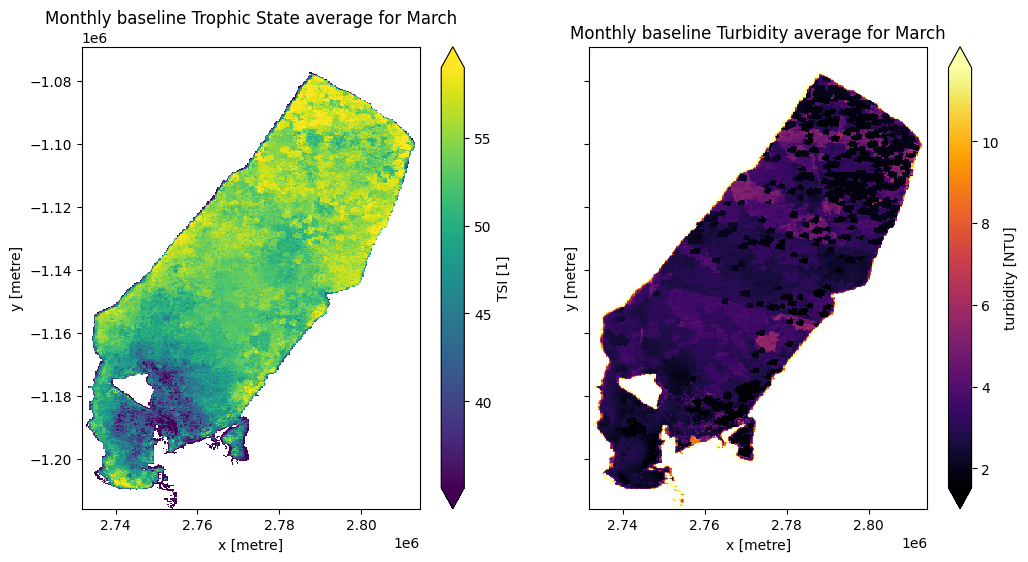

In [16]:
# Select the month of March from the xarray.Dataset
month_int = 3
to_plot = baseline_monthly_long_term_mean.sel(month=3)

# Get the month name
month_name = calendar.month_name[month_int]

# Plot 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)
to_plot["TSI"].plot(ax=ax[0], cmap="viridis", robust=True)
ax[0].set_title(f"Monthly baseline Trophic State average for {month_name}")

to_plot["turbidity"].plot(ax=ax[1], cmap="inferno", robust=True)
ax[1].set_title(f"Monthly baseline Turbidity average for {month_name}")
plt.show();

## Get monthly averages for the target years

### Load water quality data for the target years

Similar to how we [loaded data for the baseline reference period](#load-water-quality-data-for-the-baseline-period), we are going to load the Trophic State and Turbidity data available for the waterbody area and target years.

The target years are 2017, 2018, 2019, 2020 and 2021. The product `cgls_lwq300_2016_2024` has data available for the African continent for this time range.
You can visit the  [Metadata Explorer](https://explorer.digitalearth.africa/products) page for this product to view its data availability [https://explorer.digitalearth.africa/products/cgls_lwq300_2016_2024](https://explorer.digitalearth.africa/products/cgls_lwq300_2016_2024). 

Run the following cell to explore all the available measurements associated with the Lake Water Quality product `cgls_lwq300_2016_2024`.

In [17]:
product = "cgls_lwq300_2016_2024"

measurements_df = dc.list_measurements()
measurements_df.loc[product]

,name,dtype,units,nodata,aliases,flags_definition,add_offset,scale_factor
measurement,,,,,,,,
first_obs,first_obs,float32,1,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN
last_obs,last_obs,float32,1,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN
n_obs_quality_risk_sum,n_obs_quality_risk_sum,float32,1,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN
num_obs,num_obs,int32,1,0,NaN,NaN,NaN,NaN
stats_valid_obs_tsi_sum,stats_valid_obs_tsi_sum,float32,1,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN
stats_valid_obs_turbidity_sum,stats_valid_obs_turbidity_sum,float32,1,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN
trophic_state_index,trophic_state_index,float32,1,9969210000000000000000000000000000000,[TSI],NaN,NaN,NaN
turbidity_mean,turbidity_mean,float32,NTU,9969210000000000000000000000000000000,[turbidity],NaN,NaN,NaN
turbidity_sigma,turbidity_sigma,float32,NTU,9969210000000000000000000000000000000,NaN,NaN,NaN,NaN


Load the Trophic State Index (`TSI`) and Turbidity (`turbidity`) measurements for the  `cgls_lwq300_2016_2024` product for the waterbody area and the time range `('2017', '2021')`.

> The `like` parameter in `dc.load` copies the spatial, temporal extent and the CRS/resolution from an existing dataset, and uses these parameters to load a new data from a new product.

In [18]:
ds = dc.load(
    product=["cgls_lwq300_2016_2024"],
    measurements=["TSI", "turbidity"],
    like=baseline_ds.odc.geobox,
    time=("2017", "2021")
)
ds

<xarray.Dataset> Size: 194MB
Dimensions:      (time: 180, y: 489, x: 275)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2017-01-05T23:59:59.500000 ... 202...
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
Data variables:
    TSI          (time, y, x) float32 97MB 9.969e+36 9.969e+36 ... 9.969e+36
    turbidity    (time, y, x) float32 97MB 9.969e+36 9.969e+36 ... 9.969e+36
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref

The variable `ds` has returned an `xarray.Dataset` containing all data that matched the spatial (`x` and `y` dimensions) and temporal (`time` dimension) query parameters inputted into `dc.load`. 
The Trophic State Index data is contained  in the `TSI` data variable of the `xarray.Dataset` and the Turbidity data is contained in the `turbidity` data variable. 

Mask the no data value in the Trophic State Index (`TSI`) and Turbidity (`turbidity`) data variables to limit the analysis to valid pixels.
The no data value for each measurement is provided in the attributes of each data variable.

In [19]:
# View the attributes for the turbidity data variable
var = "turbidity"
ds[var].attrs

{'units': 'NTU',
 'nodata': 9969210000000000000000000000000000000,
 'crs': 'PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",30],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6933"]]',
 'grid_mapping': 'spatial_ref'}

In [20]:
# Mask no data in the trophic_state_index and turbidity bands
var = "TSI"
ds[var] = ds[var].where(ds[var]!=float(ds[var].nodata))

var = "turbidity"
ds[var] = ds[var].where(ds[var]!=float(ds[var].nodata))

ds

<xarray.Dataset> Size: 194MB
Dimensions:      (time: 180, y: 489, x: 275)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2017-01-05T23:59:59.500000 ... 202...
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
Data variables:
    TSI          (time, y, x) float32 97MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 97MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref

To verify that the no data values have been masked, print the maximum value of each data variable.

In [21]:
print(ds.max())

<xarray.Dataset> Size: 20B
Dimensions:      ()
Coordinates:
    spatial_ref  int32 4B 6933
Data variables:
    TSI          float64 8B 100.0
    turbidity    float64 8B 258.9


The maximum values for the TSI and turbidity data variables are reasonable, which shows that the no data values have been masked correctly.

### Resample the decadal timeseries

Downsample the loaded data for the target years to a monthly timeseries.

In [22]:
monthly_timeseries = ds.resample(time="1ME").mean()
monthly_timeseries

<xarray.Dataset> Size: 65MB
Dimensions:      (time: 60, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2017-01-31 2017-02-28 ... 2021-12-31
Data variables:
    TSI          (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref

Plot the data for a single month from the downsampled Trophic State Index and Turbidity data.

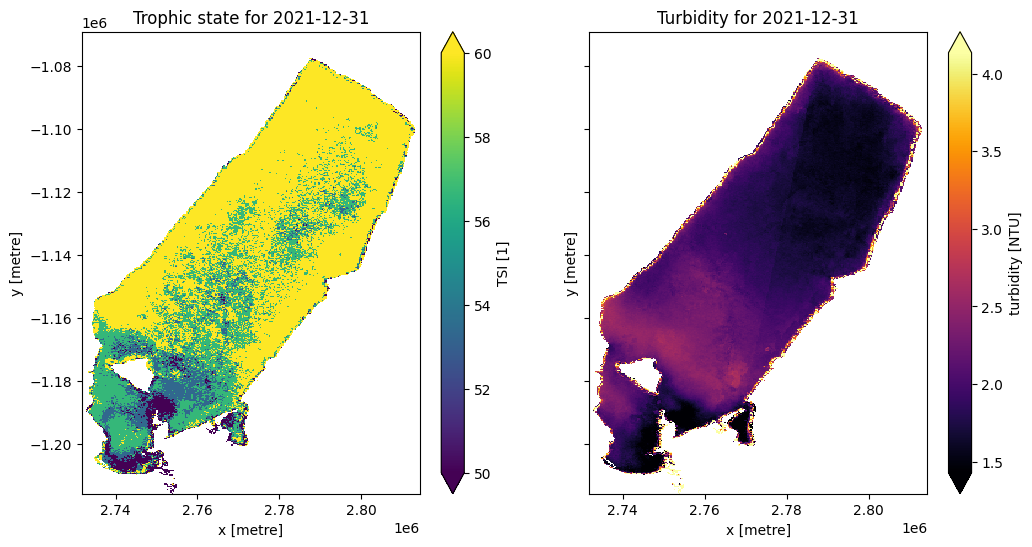

In [23]:
to_plot = monthly_timeseries.isel(time=-1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)
to_plot["TSI"].plot(ax=ax[0], cmap="viridis", robust=True)
ax[0].set_title(f"Trophic state for {to_plot.time.values.astype('datetime64[D]')}")

to_plot["turbidity"].plot(ax=ax[1], cmap="inferno", robust=True)
ax[1].set_title(f"Turbidity for {to_plot.time.values.astype('datetime64[D]')}")
plt.show();

## Produce a monthly deviation synthesis

The deviation from the corresponding monthly multiannual baseline is computed using the following equation:
$$
\frac{\text{Month}_\text{average} - \text{Month}_\text{baseline}}{\text{Month}_\text{baseline}} \times 100 
$$

The function defined below gets the deviations for each month in a target year data from the multiannual baseline `xarray.Dataset`  `baseline_monthly_long_term_mean`.

In [24]:
def get_monthly_deviations(year_data, baseline):
    deviations = year_data.groupby("time.month").apply(
        lambda x: (
            (x - baseline.sel(month=x["time.month"]))
            / baseline.sel(month=x["time.month"])
        )
        * 100
    )
   
    return  deviations.drop_vars("month")

To apply the function to each year in the `xarray.Dataset` `ds`, use the  `.groupby` method to first group the data by year and the `.map` method to apply the `get_monthly_deviations` function to each group (year).

> See the [xarray documentation](https://docs.xarray.dev/en/stable/user-guide/groupby.html#groupby-group-and-bin-data) on grouping and binning data for more information on how these methods work.

In [25]:
# Get the monthly deviations
monthly_deviations = monthly_timeseries.groupby("time.year").map(lambda year_data: get_monthly_deviations(year_data, baseline_monthly_long_term_mean)
)
monthly_deviations

<xarray.Dataset> Size: 65MB
Dimensions:      (time: 60, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2017-01-31 2017-02-28 ... 2021-12-31
Data variables:
    TSI          (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan

We can now view the monthly deviation for a single month. 

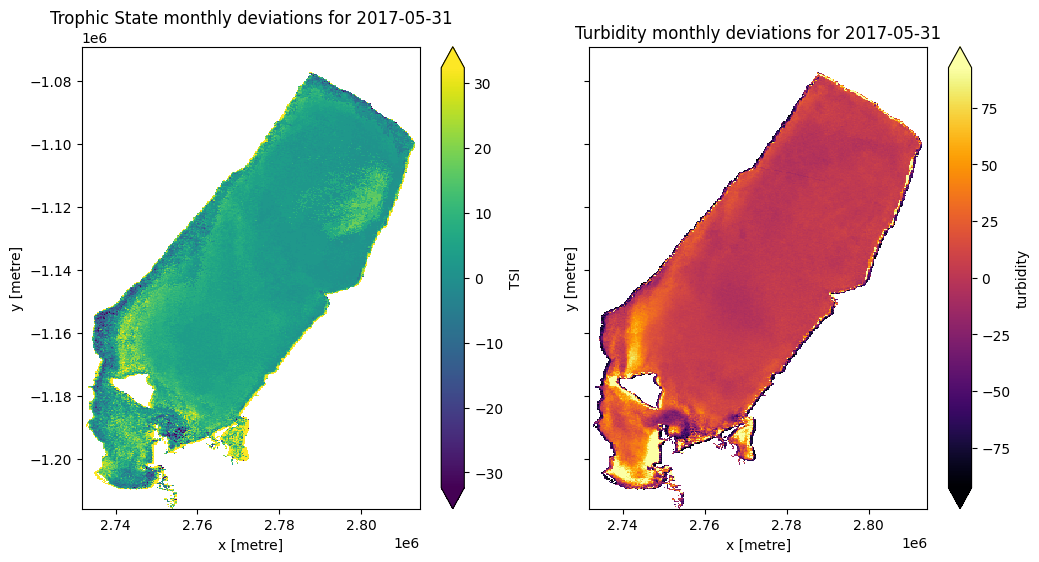

In [26]:
# Select a single time step to plot
to_plot = monthly_deviations.isel(time=4)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

to_plot["TSI"].plot(ax=ax[0], cmap="viridis", robust=True)
ax[0].set_title(f"Trophic State monthly deviations for {to_plot.time.values.astype('datetime64[D]')}")

to_plot["turbidity"].plot(ax=ax[1], cmap="inferno", robust=True)
ax[1].set_title(f"Turbidity monthly deviations for {to_plot.time.values.astype('datetime64[D]')}")
plt.show();

## Classify the monthly deviations

Classify each valid pixel in the `monthly_devations` `xarray.Dataset` using the following deviation ranges:
 - < 25 per cent (low)
 - 25–50 per cent (medium)
 - 50–100 per cent (high)
 - \> 100 per cent (extreme)

The deviation categories will be stored in a seperate `xarray.Dataset`. 
Begin by creating an empty `xarray.Dataset` with the  same shape and type as the `monthly_devations` `xarray.Dataset`.

In [27]:
monthly_deviation_classes = xr.full_like(monthly_deviations, fill_value=np.nan)
monthly_deviation_classes 

<xarray.Dataset> Size: 65MB
Dimensions:      (time: 60, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2017-01-31 2017-02-28 ... 2021-12-31
Data variables:
    TSI          (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan

Categorize the pixels in the `TSI` data variable of the  `monthly_devations` `xarray.Dataset` and add the classifed pixels to the `TSI` data variable of the `monthly_deviation_classes` `xarray.Dataset`.

The mapping below shows the pixel values representing each deviation category:
- 1 -> low
- 2 -> medium
- 3 -> high
- 4 -> extreme

In [28]:
var = "TSI"

conditions = [(monthly_deviations[var] <= 25), 
              ((monthly_deviations[var] > 25) & (monthly_deviations[var] <= 50)),
              ((monthly_deviations[var] > 50) & (monthly_deviations[var] <= 100)),
              (monthly_deviations[var] > 100)]

classes = [1,2,3,4]
monthly_deviation_classes[var].data = np.select(conditions, classes, default=np.nan)
monthly_deviation_classes[var]

<xarray.DataArray 'TSI' (time: 60, y: 489, x: 275)> Size: 65MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2017-01-31 2017-02-28 ... 2021-12-31

Apply the same classification to the `turbidity` variable.

In [29]:
var = "turbidity"

conditions = [(monthly_deviations[var] <= 25), 
              ((monthly_deviations[var] > 25) & (monthly_deviations[var] <= 50)),
              ((monthly_deviations[var] > 50) & (monthly_deviations[var] <= 100)),
              (monthly_deviations[var] > 100)]

classes = [1,2,3,4]
monthly_deviation_classes[var].data = np.select(conditions, classes, default=np.nan)
monthly_deviation_classes[var]

<xarray.DataArray 'turbidity' (time: 60, y: 489, x: 275)> Size: 65MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2017-01-31 2017-02-28 ... 2021-12-31

Plot the deviation classes for a month in the target years.

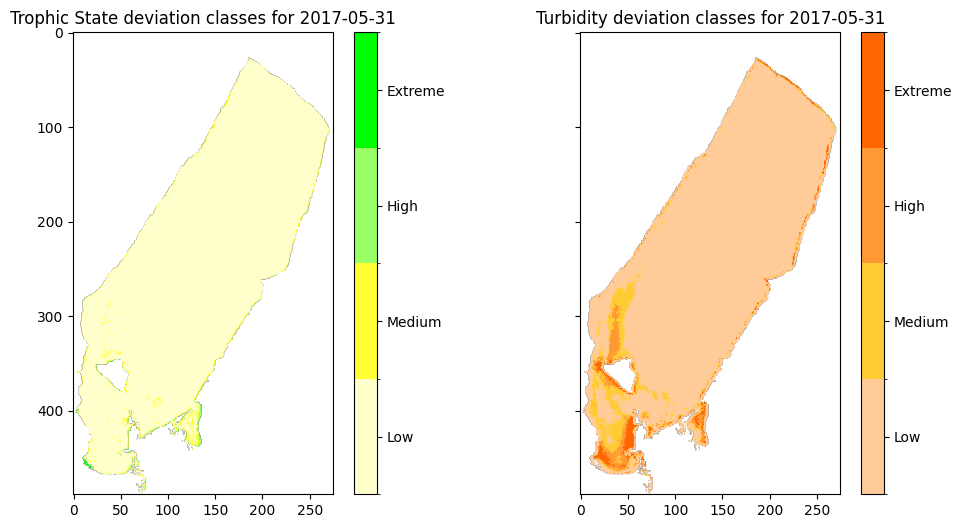

In [30]:
# Plot the deviation classes for  a single time step
to_plot = monthly_deviation_classes.isel(time=4)

classes = [1,2,3,4]
class_labels = ['Low', 'Medium', 'High', 'Extreme']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

colors = ["#FFFFCC","#FFFF33", "#99FF66", "#00FF00" ]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(min(classes), max(classes)+2)-0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax[0].imshow(to_plot["TSI"], cmap=cmap, norm=norm)
cb = plt.colorbar(im, ticks=classes)
cb.ax.set_yticklabels(class_labels)
ax[0].set_title(f"Trophic State deviation classes for {to_plot.time.values.astype('datetime64[D]')}")

colors = ["#FFCC99","#FFCC33", "#FF9933", "#FF6600" ]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(min(classes), max(classes)+2)-0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax[1].imshow(to_plot["turbidity"], cmap=cmap, norm=norm)
cb = plt.colorbar(im, ticks=classes)
cb.ax.set_yticklabels(class_labels)
ax[1].set_title(f"Turbidity deviation classes for {to_plot.time.values.astype('datetime64[D]')}")

plt.show();

## Produce the annual deviation synthesis

To produce the annual deviation synthesis, we aggregate the monthly deviations by calendar year. This summarizes the average deviation for each year. 

In [31]:
annual_deviations = monthly_deviations.groupby("time.year").mean()
annual_deviations

<xarray.Dataset> Size: 5MB
Dimensions:      (year: 5, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * year         (year) int64 40B 2017 2018 2019 2020 2021
Data variables:
    TSI          (year, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    turbidity    (year, y, x) float32 3MB nan nan nan nan ... nan nan nan nan

Plot the annual deviations for a target year in the cell below. 

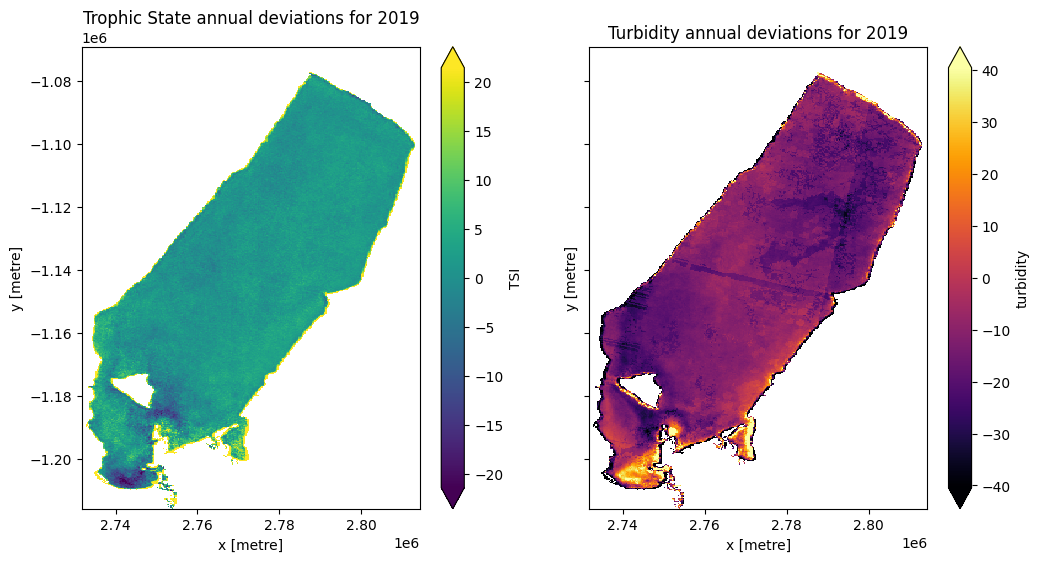

In [32]:
to_plot = annual_deviations.isel(year=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

to_plot["TSI"].plot(ax=ax[0], cmap="viridis", robust=True)
ax[0].set_title(f"Trophic State annual deviations for {to_plot.year.values}")

to_plot["turbidity"].plot(ax=ax[1], cmap="inferno", robust=True)
ax[1].set_title(f"Turbidity annual deviations for {to_plot.year.values}")
plt.show();

## Classify the annual deviations

Using the same method as we have used previously when [classifying the monthly deviations](#classify-the-monthly-deviations), we will classify the annual deviations in the cells below. 
Each valid pixel in the `annual_deviations` `xarray.Dataset` will be classified into the following deviation ranges:
 - < 25 per cent (low)
 - 25–50 per cent (medium)
 - 50–100 per cent (high)
 - \> 100 per cent (extreme)

The mapping below shows the pixel values representing each deviation category:
- 1 -> low
- 2 -> medium
- 3 -> high
- 4 -> extreme

Create an empty `xarray.Dataset` with the  same shape and type as the `annual_deviations` `xarray.Dataset`.

In [33]:
annual_deviation_classes = xr.full_like(annual_deviations, fill_value=np.nan)
annual_deviation_classes 

<xarray.Dataset> Size: 5MB
Dimensions:      (year: 5, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * year         (year) int64 40B 2017 2018 2019 2020 2021
Data variables:
    TSI          (year, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    turbidity    (year, y, x) float32 3MB nan nan nan nan ... nan nan nan nan

Categorize the pixels in the `TSI` data variable of the  `annual_deviations` `xarray.Dataset` and add the classifed pixels to the `TSI` data variable of the `annual_deviation_classes` `xarray.Dataset`.

In [34]:
var = "TSI"

conditions = [(annual_deviations[var] <= 25), 
              ((annual_deviations[var] > 25) & (annual_deviations[var] <= 50)),
              ((annual_deviations[var] > 50) & (annual_deviations[var] <= 100)),
              (annual_deviations[var] > 100)
             ]

classes = [1,2,3,4]
annual_deviation_classes[var].data = np.select(conditions, classes, default=np.nan)
annual_deviation_classes[var]

<xarray.DataArray 'TSI' (year: 5, y: 489, x: 275)> Size: 5MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * year         (year) int64 40B 2017 2018 2019 2020 2021

Apply the same classification to the `turbidity` variable.

In [35]:
var = "turbidity"

conditions = [(annual_deviations[var] <= 25), 
              ((annual_deviations[var] > 25) & (annual_deviations[var] <= 50)),
              ((annual_deviations[var] > 50) & (annual_deviations[var] <= 100)),
              (annual_deviations[var] > 100)
             ]

classes = [1,2,3,4]
annual_deviation_classes[var].data = np.select(conditions, classes, default=np.nan)
annual_deviation_classes[var]

<xarray.DataArray 'turbidity' (year: 5, y: 489, x: 275)> Size: 5MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * year         (year) int64 40B 2017 2018 2019 2020 2021

Plot the deviation classes for a target year.

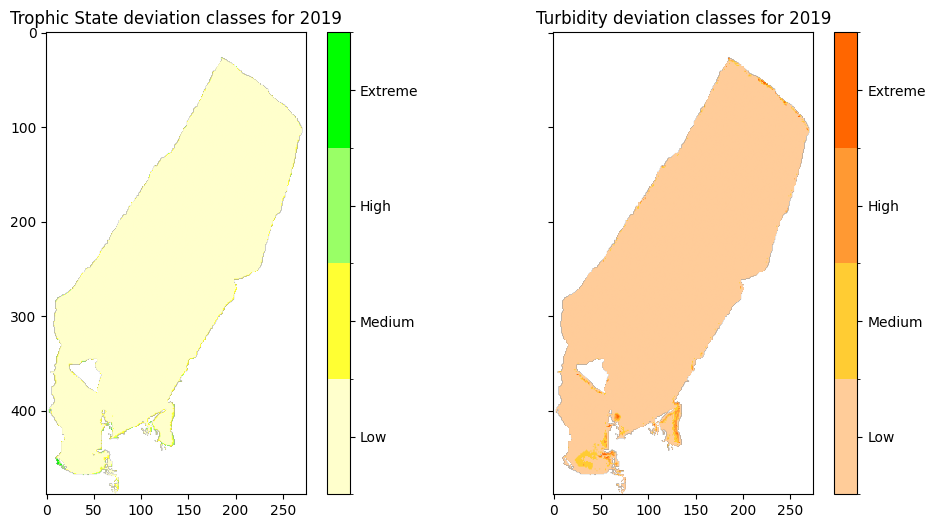

In [36]:
to_plot = annual_deviation_classes.isel(year=2)

classes = [1,2,3,4]
class_labels = ['Low', 'Medium', 'High', 'Extreme']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

colors = ["#FFFFCC","#FFFF33", "#99FF66", "#00FF00" ]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(min(classes), max(classes)+2)-0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax[0].imshow(to_plot["TSI"], cmap=cmap, norm=norm)
cb = plt.colorbar(im, ticks=classes)
cb.ax.set_yticklabels(class_labels)
ax[0].set_title(f"Trophic State deviation classes for {to_plot.year.values}")


colors = ["#FFCC99","#FFCC33", "#FF9933", "#FF6600" ]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(min(classes), max(classes)+2)-0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax[1].imshow(to_plot["turbidity"], cmap=cmap, norm=norm)
cb = plt.colorbar(im, ticks=classes)
cb.ax.set_yticklabels(class_labels)
ax[1].set_title(f"Turbidity deviation classes for {to_plot.year.values}")

plt.show();

## Summarize the monthly statistics for the waterbody

In this step, we are to going get the relative share of pixels for the waterbody that fall in each deviation category for every month in the target years.

The cell below gets the pixel count for each deviation category in the `monthly_deviation_classes` `xarray.Dataset` by summarizing across the spatial dimensions `"x"` and `"y"`. 

In [37]:
monthly_low_count = (monthly_deviation_classes == 1).astype(int).sum(dim=["x", "y"])
monthly_medium_count = (monthly_deviation_classes == 2).astype(int).sum(dim=["x", "y"])
monthly_high_count = (monthly_deviation_classes == 3).astype(int).sum(dim=["x", "y"])
monthly_extreme_count = (monthly_deviation_classes == 4).astype(int).sum(dim=["x", "y"])

The next step is to get the number of valid observations in the `monthly_deviation_classes` `xarray.Dataset`.

In [38]:
monthly_valid_pixels_count = (~monthly_deviations.isnull()).astype(int).sum(dim=["x", "y"])

Finally get the relative share of pixels within each deviation category as a percentage.

In [39]:
monthly_low_perc = (monthly_low_count / monthly_valid_pixels_count) * 100
monthly_medium_perc = (monthly_medium_count / monthly_valid_pixels_count) * 100
monthly_high_perc = (monthly_high_count / monthly_valid_pixels_count) * 100
monthly_extreme_perc = (monthly_extreme_count / monthly_valid_pixels_count) * 100

Plot the percentage of the waterbody that falls into each deviation category for turbidity and trophic state monthly data. 

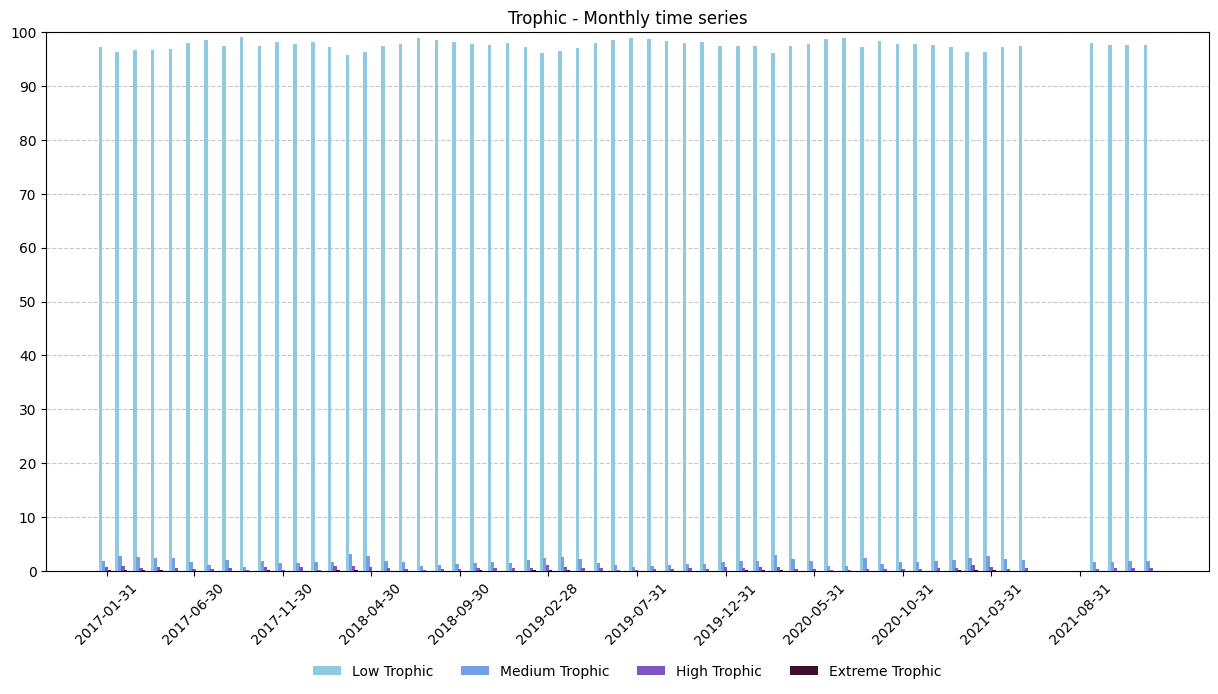

In [40]:
## X- axis
# Get the x values to use in the plot.
x = matplotlib.dates.date2num(monthly_valid_pixels_count.time.values)
# Convert to string to use as x axis labels.
x_labels = list(np.datetime_as_string(monthly_valid_pixels_count.time.values, unit='D'))
# Prevent crowding in the x axis.
rolling_step = 5
# Size of bars
bar_width = 6

## Y axis 
ymin=0
ymax=100
y_ticks = list(range(ymin, ymax+1, 10))
               
# Plot
var = "TSI"
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(x - 10, monthly_low_perc[var].values, width=bar_width, align='center', color="#90C9E0", label="Low Trophic", zorder=3)
ax.bar(x - 5, monthly_medium_perc[var].values, width=bar_width, align='center', color="#749FE4", label="Medium Trophic", zorder=3)
ax.bar(x, monthly_high_perc[var].values, width=bar_width, align='center', color="#7D56C1", label="High Trophic", zorder=3)
ax.bar(x + 5, monthly_extreme_perc[var].values, width=bar_width, align='center', color="#3F0F2D", label="Extreme Trophic", zorder=3)

ax.set_ylim(ymin=ymin, ymax=ymax)
ax.set_yticks(y_ticks)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax.legend(
    loc='upper center',           
    bbox_to_anchor=(0.5, -0.15),  
    ncol=4,                       
    frameon=False)

# Enable horizontal grid lines at y-ticks
ax.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)
ax.set_xticks(ticks=x[::rolling_step], labels=x_labels[::rolling_step], rotation=45)
plt.title("Trophic - Monthly time series")
plt.show();

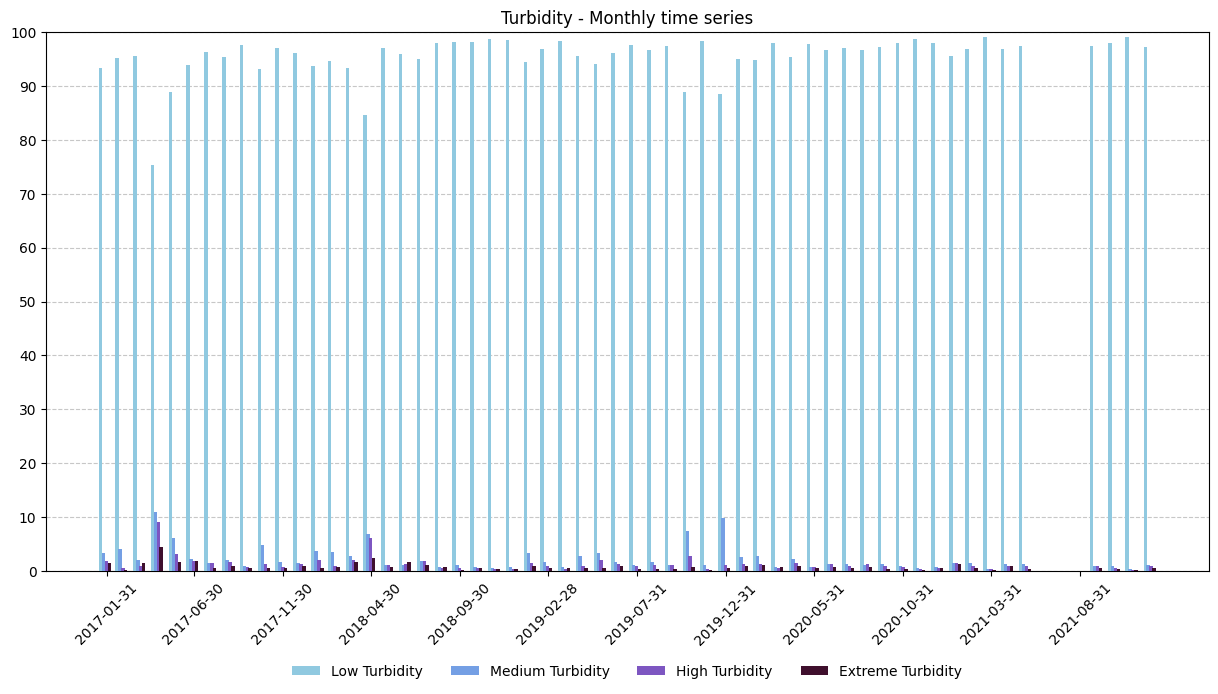

In [41]:
## X- axis
# Get the x values to use in the plot.
x = matplotlib.dates.date2num(monthly_valid_pixels_count.time.values)
# Convert to string to use as x axis labels.
x_labels = list(np.datetime_as_string(monthly_valid_pixels_count.time.values, unit='D'))
# Prevent crowding in the x axis.
rolling_step = 5
# Size of bars
bar_width = 6

## Y axis 
ymin=0
ymax=100
y_ticks = list(range(ymin, ymax+1, 10))
               
# Plot
var = "turbidity"
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(x - 10, monthly_low_perc[var].values, width=bar_width, align='center', color="#90C9E0", label="Low Turbidity", zorder=3)
ax.bar(x - 5, monthly_medium_perc[var].values, width=bar_width, align='center', color="#749FE4", label="Medium Turbidity", zorder=3)
ax.bar(x, monthly_high_perc[var].values, width=bar_width, align='center', color="#7D56C1", label="High Turbidity", zorder=3)
ax.bar(x + 5, monthly_extreme_perc[var].values, width=bar_width, align='center', color="#3F0F2D", label="Extreme Turbidity", zorder=3)

ax.set_ylim(ymin=ymin, ymax=ymax)
ax.set_yticks(y_ticks)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax.legend(
    loc='upper center',           
    bbox_to_anchor=(0.5, -0.15),  
    ncol=4,                       
    frameon=False)

# Enable horizontal grid lines at y-ticks
ax.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)
ax.set_xticks(ticks=x[::rolling_step], labels=x_labels[::rolling_step], rotation=45)
plt.title("Turbidity - Monthly time series")
plt.show();

## Summarize the annual statistics for the waterbody

In this step, we are to going get the relative share of pixels for the waterbody that fall into each deviation category for every year in the target years.

The cell below gets the pixel count for each deviation category in the `annual_deviation_classes` `xarray.Dataset` by summarizing across the spatial dimensions `"x"` and `"y"`. 

In [42]:
annual_low_count = (annual_deviation_classes == 1).astype(int).sum(dim=["x", "y"])
annual_medium_count = (annual_deviation_classes == 2).astype(int).sum(dim=["x", "y"])
annual_high_count = (annual_deviation_classes == 3).astype(int).sum(dim=["x", "y"])
annual_extreme_count = (annual_deviation_classes == 4).astype(int).sum(dim=["x", "y"])

The next step is to get the number of valid observations in the `annual_valid_pixels_count` `xarray.Dataset`.

In [43]:
annual_valid_pixels_count = (~annual_deviations.isnull()).astype(int).sum(dim=["x", "y"])

Finally get the relative share of pixels within each deviation category as a percentage.

In [44]:
annual_low_perc = (annual_low_count / annual_valid_pixels_count) * 100
annual_medium_perc = (annual_medium_count / annual_valid_pixels_count) * 100
annual_high_perc = (annual_high_count / annual_valid_pixels_count) * 100
annual_extreme_perc = (annual_extreme_count / annual_valid_pixels_count) * 100

Plot the percentage of the waterbody that falls into each deviation category for turbidity and trophic state annual data. 

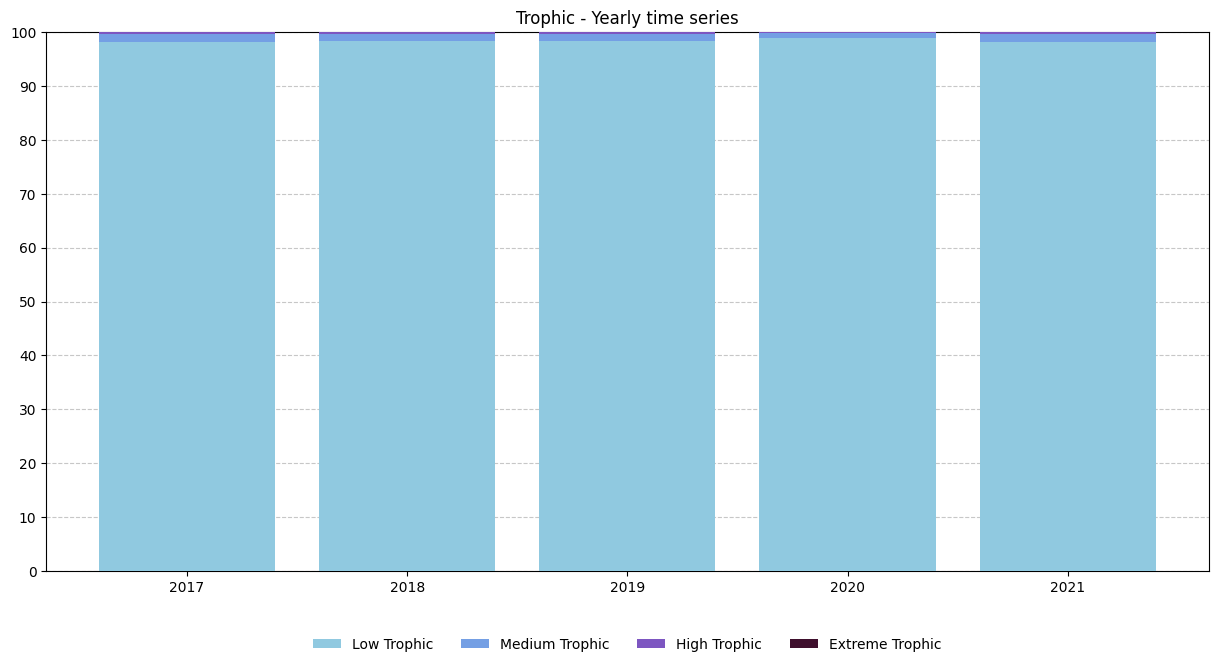

In [45]:
## X axis
years = annual_extreme_perc.year.values
bottom = np.zeros(len(years))

## Y axis 
ymin=0
ymax=100
y_ticks = list(range(ymin, ymax+1, 10))

## Plot
var = "TSI"
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(years, annual_low_perc[var].values, color="#90C9E0", label="Low Trophic",  zorder=3)
ax.bar(years, annual_medium_perc[var].values, color="#749FE4", label="Medium Trophic", bottom=annual_low_perc[var].values , zorder=3)
ax.bar(years, annual_high_perc[var].values, color="#7D56C1", label="High Trophic", bottom=annual_medium_perc[var].values + annual_low_perc[var].values, zorder=3)
ax.bar(years, annual_extreme_perc[var].values, color="#3F0F2D", label="Extreme Trophic", bottom=annual_high_perc[var].values + annual_medium_perc[var].values + annual_low_perc[var].values,  zorder=3)

ax.legend(
    loc='upper center',           
    bbox_to_anchor=(0.5, -0.10),  
    ncol=4,                       
    frameon=False)

ax.set_ylim(ymin=ymin, ymax=ymax)
ax.set_yticks(y_ticks)
ax.grid(True, axis='y', linestyle='--', alpha=0.7,  zorder=0)
plt.title("Trophic - Yearly time series")
plt.show();

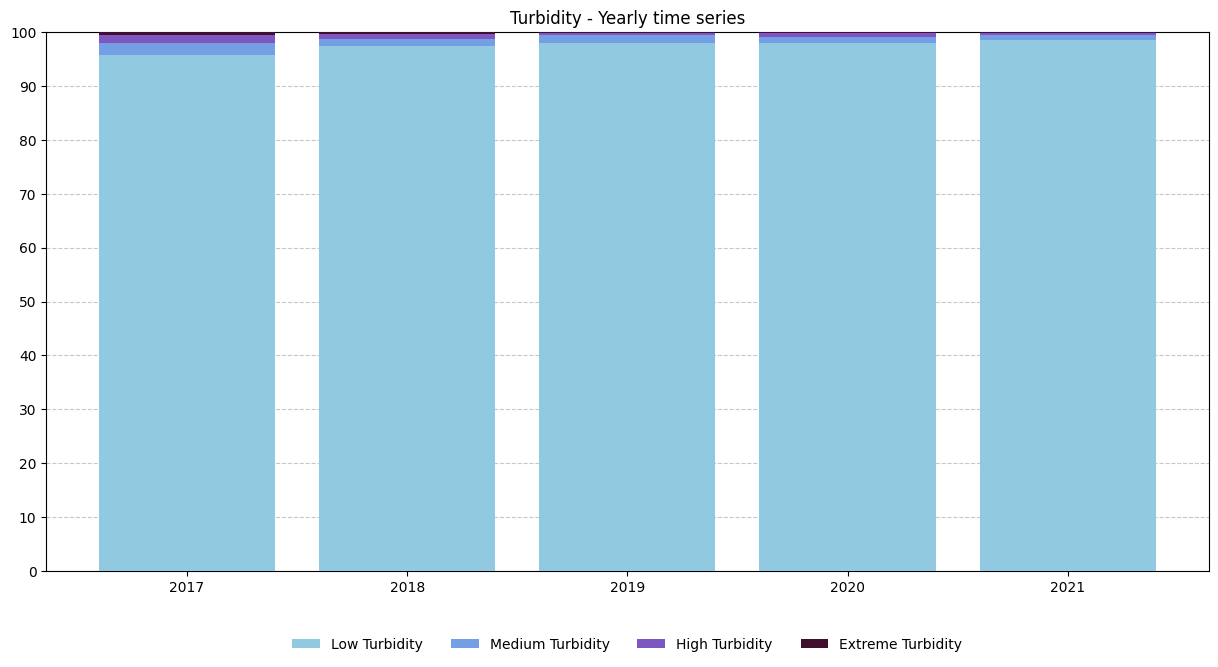

In [46]:
## X axis
years = annual_extreme_perc.year.values
bottom = np.zeros(len(years))

## Y axis 
ymin=0
ymax=100
y_ticks = list(range(ymin, ymax+1, 10))

## Plot
var = "turbidity"
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(years, annual_low_perc[var].values, color="#90C9E0", label="Low Turbidity",  zorder=3)
ax.bar(years, annual_medium_perc[var].values, color="#749FE4", label="Medium Turbidity", bottom=annual_low_perc[var].values , zorder=3)
ax.bar(years, annual_high_perc[var].values, color="#7D56C1", label="High Turbidity", bottom=annual_medium_perc[var].values + annual_low_perc[var].values, zorder=3)
ax.bar(years, annual_extreme_perc[var].values, color="#3F0F2D", label="Extreme Turbidity", bottom=annual_high_perc[var].values + annual_medium_perc[var].values + annual_low_perc[var].values,  zorder=3)

ax.legend(
    loc='upper center',           
    bbox_to_anchor=(0.5, -0.10),  
    ncol=4,                       
    frameon=False)

ax.set_ylim(ymin=ymin, ymax=ymax)
ax.set_yticks(y_ticks)
ax.grid(True, axis='y', linestyle='--', alpha=0.7,  zorder=0)
plt.title("Turbidity - Yearly time series")
plt.show();

## Waterbody classification

A waterbody is defined as affected if the following conditions apply: the sum of the number of pixels in the high and extreme categories is greater than the sum of pixels in the low and medium categories i.e. (high+extreme) > (low+medium) from the annual deviation synthesis.

If a lake is classified as "affected" this does not mean that a lake is considered to be of good or bad quality, only that a lake water event has occurred and has been recorded. Each event is considered indicative of a degradation in water quality.

For each target year check if the waterbody has been affected (`True`) or not affected (`False`). 

In [47]:
affected = (annual_high_count + annual_extreme_count) > (annual_low_count + annual_medium_count)
affected_df = affected.to_dataframe().drop(columns=["spatial_ref"])
affected_df

,TSI,turbidity
year,,
2017,False,False
2018,False,False
2019,False,False
2020,False,False
2021,False,False


___

## Additional information

**License**: The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Compatible datacube version:**

In [48]:
import datacube
print(datacube.__version__)

1.8.20


**Last Tested:**

In [49]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-06-25'